In [78]:
import warnings
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
import sys
import scienceplots
sys.path.append("../FinRL-Library")
plt.style.use('science')

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - (time_window) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.columns = np.insert(tiks,0,'POS')
            df_actions.index = df_date.date
            account_memory = df_account_value
            actions_memory = df_actions

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv


df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
def mvo_data(data, INDICATORS, TEST_START_DATE, TEST_END_DATE):
    final_result = []
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df
def mvo(data, solver='OSQP',window=1, rf=0.02, pct=0.001,objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window":window

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective,cost=pct)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result
    

# DOW

In [89]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow[df_dow["date"] > DATA_START_DATE])
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 29, State Space: 88


In [74]:

covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0,rf=0)
min_variance_portfolio = mvo(covs,pct=0)

begin_total_asset:50000
end_total_asset:56619.055353935655
Sharpe:  0.7385209263759179
Test Finished!
episode_return 1.132381107078713


begin_total_asset:50000
end_total_asset:57820.5213443752
Sharpe:  0.6475347080305256
Test Finished!
episode_return 1.156410426887504


In [66]:
def train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=False,use_dsr=False,use_sortino=False,model_name='a2c'
                ,iterations = 50000,save=True,load=False,tag='tag',features=["close","log_return"],t=5,args=None,indicators =None,starting_capital = 50_000):

    env_kwargs = {
        "initial_amount": starting_capital, 
        "normalize_df":None,
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
        'use_differentail_sharpe_ratio':use_dsr,
        
    }
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    env_kwargs = {
        "initial_amount": starting_capital, 
        "normalize_df":None,
        'comission_fee_pct':transaction_fee,
        "features" :features,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
        'use_differentail_sharpe_ratio':use_dsr,
    }

    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  verbose=0,
                                model_kwargs = args)

    
    if not load:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name,
                                    total_timesteps=iterations)
    else:
        print('loading model')
        model = model_agent.load('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag,env =train_environment)
    if save and not load:
        model.save('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Episode:1
Initial portfolio value:8000
Final portfolio value: 10243.0498046875
Final accumulative portfolio value: 1.2803812255859375
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Episode:1
Initial portfolio value:8000
Final portfolio value: 5966.62451171875
Final accumulative portfolio value: 0.7458280639648438


KeyboardInterrupt: 

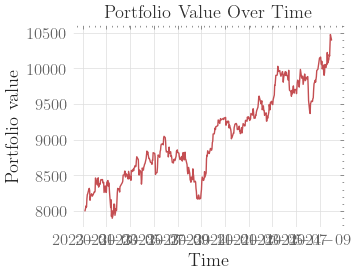

In [97]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=1000,model_name='ddpg',save=True)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=1000,save=True)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=1000,save=True)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=1000,save=True)

In [29]:
iterations = 10_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=False)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=False)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=False)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=False)

Initial portfolio value:8000
Final portfolio value: 11463.6416015625
Final accumulative portfolio value: 1.4329552001953125
Maximum DrawDown: -0.32207052297871597
Sharpe ratio: 0.2500618862343456
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3.27e+03     |
|    ep_rew_mean          | 0.371        |
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 2            |
|    time_elapsed         | 99           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.010997624  |
|    clip_fraction        | 0.0914       |
|    clip_range           | 0.2          |
|    entropy_loss         | -42.6        |
|    explained_variance   | -1.38        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.459       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0

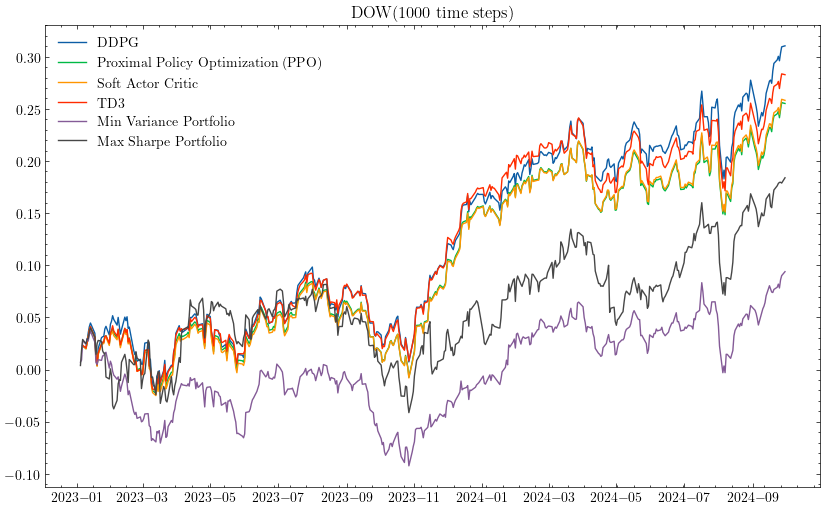

In [48]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(1000 time steps)')

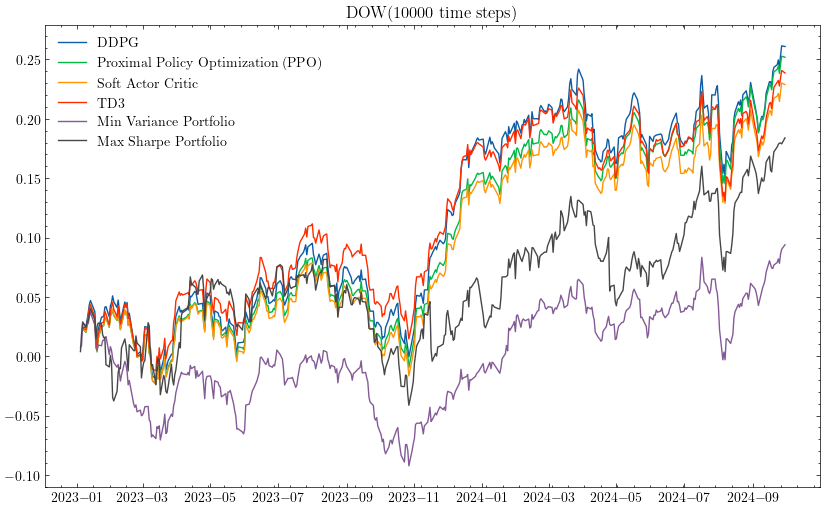

In [43]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(10000 time steps)')

In [49]:
iterations = 30_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=True,tag='dow30')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='dow30')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=True,tag='dow30')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial portfolio value:8000
Final portfolio value: 44217.9765625
Final accumulative portfolio value: 5.5272470703125
Maximum DrawDown: -0.3114089275408628
Sharpe ratio: 0.8979783301491956
Initial portfolio value:8000
Final portfolio value: 44523.99609375
Final accumulative portfolio value: 5.56549951171875
Maximum DrawDown: -0.3274275540525047
Sharpe ratio: 0.8830368983570219
Initial portfolio value:8000
Final portfolio value: 43535.859375
Final accumulative portfolio value: 5.441982421875
Maximum DrawDown: -0.3141870522438056
Sharpe ratio: 0.8772791841582078
Initial portfolio value:8000
Final portfolio value: 42755.125
Final accumulative portfolio value: 5.344390625
Maximum DrawDown: -0.3056047763254146
Sharpe ratio: 0.8758619346451
------------------------------------
| rollout/           |             |
|    ep_len_mean    

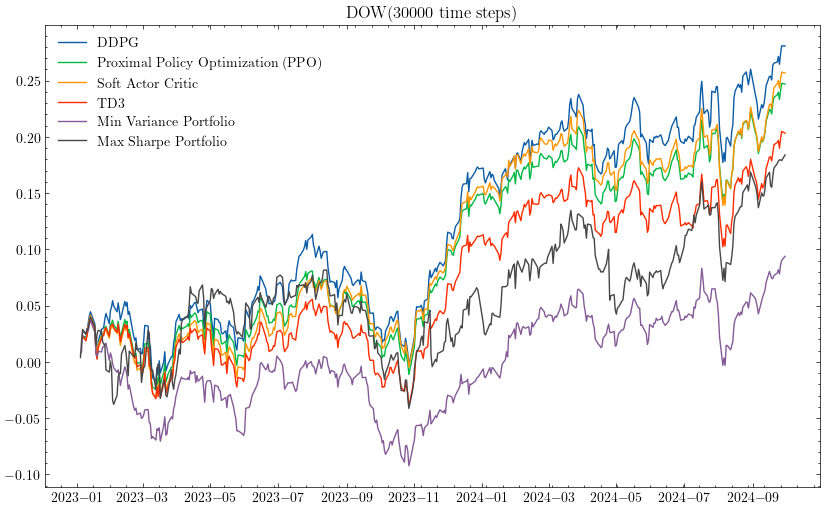

In [50]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [ ]:
iterations = 60_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,save=True,tag='dow30')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,save=True,tag='dow30')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,save=True,tag='dow30')

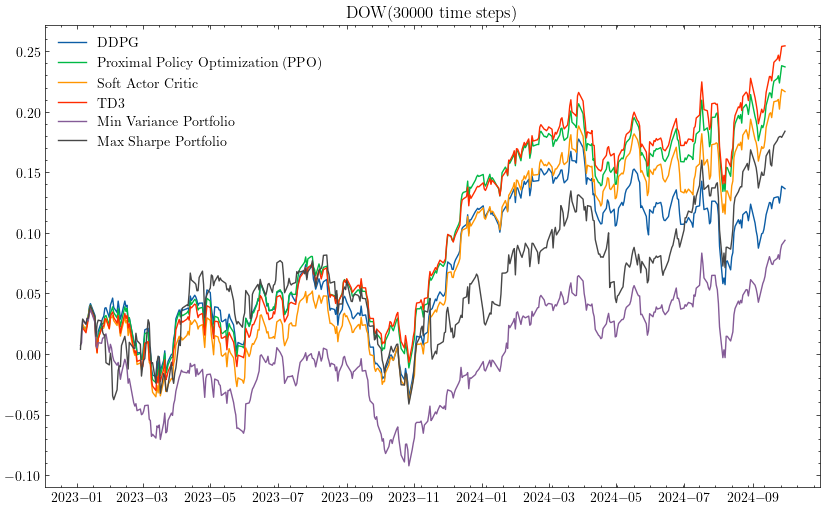

In [52]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test_df'][0].get('date'),(result_ddpg['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test_df'][0].get('date'),(result_ppo['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test_df'][0].get('date'),(result_td3['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [115]:
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1_000_000,load=True,tag='dow30')

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 16350.5009765625
Final accumulative portfolio value: 2.0438126220703126
hit end!


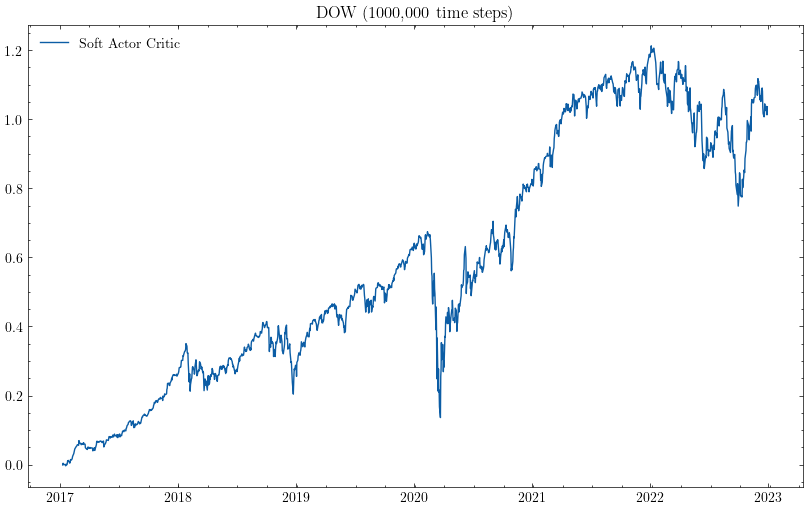

In [79]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_sac['test_df'][0].get('date'),(result_sac['test_df'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')

    plt.legend()
    plt.title('DOW (1000,000 time steps)')

In [113]:
len(train_data.tic.unique().tolist())


29

In [120]:
weights = pd.DataFrame(result_sac['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.insert(0,'Cash')
weights.columns = columns
columns.append('date')
weights['date'] = result_sac['test'][0].date
# weights["sum"] = weights.drop(columns=["date"]).sum(axis=1)
weights

Cash      AAPL      AMGN       AXP        BA       CAT       CRM  \
0     1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.032191  0.034153  0.034244  0.033971  0.034971  0.033546  0.034559   
2     0.031988  0.034094  0.033579  0.033554  0.034690  0.033126  0.035197   
3     0.032275  0.034078  0.034077  0.033675  0.034667  0.032883  0.034393   
4     0.032134  0.033995  0.034371  0.033485  0.034887  0.033137  0.034722   
...        ...       ...       ...       ...       ...       ...       ...   
1500  0.032504  0.033639  0.034455  0.033468  0.033747  0.032777  0.034571   
1501  0.032009  0.033836  0.033896  0.033823  0.034773  0.033148  0.034414   
1502  0.032129  0.033615  0.034102  0.033404  0.034781  0.033413  0.034824   
1503  0.032570  0.033473  0.034403  0.033444  0.035001  0.032904  0.034324   
1504  0.031787  0.034630  0.034058  0.034001  0.034485  0.032729  0.035228   

          CSCO       CVX       DIS  ...      MSFT       NKE        PG  \
0     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1     0.034086  0.033778  0.034174  ...  0.032560  0.033517  0.032666   
2     0.033385  0.034087  0.034343  ...  0.032654  0.033221  0.032940   
3     0.033817  0.034174  0.033681  ...  0.032364  0.033579  0.033160   
4     0.033855  0.034037  0.034310  ...  0.032565  0.033959  0.033022   
...        ...       ...       ...  ...       ...       ...       ...   
1500  0.033930  0.033759  0.034429  ...  0.032008  0.034254  0.033399   
1501  0.033807  0.034915  0.034515  ...  0.032481  0.033310  0.032943   
1502  0.033782  0.034358  0.033512  ...  0.032262  0.033992  0.033224   
1503  0.033924  0.033911  0.033659  ...  0.032609  0.033324  0.032978   
1504  0.033768  0.033882  0.034982  ...  0.033079  0.033946  0.032738   

           TRV       UNH         V        VZ       WBA       WMT       date  
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 2017-01-09  
1     0.032472  0.033983  0.032580  0.032145  0.033414  0.032884 2017-01-10  
2     0.032453  0.033930  0.032757  0.031774  0.033904  0.033081 2017-01-11  
3     0.032357  0.034251  0.032671  0.032340  0.033282  0.032942 2017-01-12  
4     0.032539  0.033887  0.032595  0.031960  0.033292  0.032662 2017-01-13  
...        ...       ...       ...       ...       ...       ...        ...  
1500  0.032454  0.034307  0.032725  0.032866  0.033565  0.033022 2022-12-22  
1501  0.032729  0.034142  0.032653  0.031968  0.033365  0.033024 2022-12-23  
1502  0.032628  0.034038  0.032761  0.032772  0.033061  0.033081 2022-12-27  
1503  0.032492  0.034224  0.032900  0.032081  0.033078  0.032900 2022-12-28  
1504  0.032312  0.033705  0.032811  0.032080  0.032888  0.032877 2022-12-29  

[1505 rows x 31 columns]

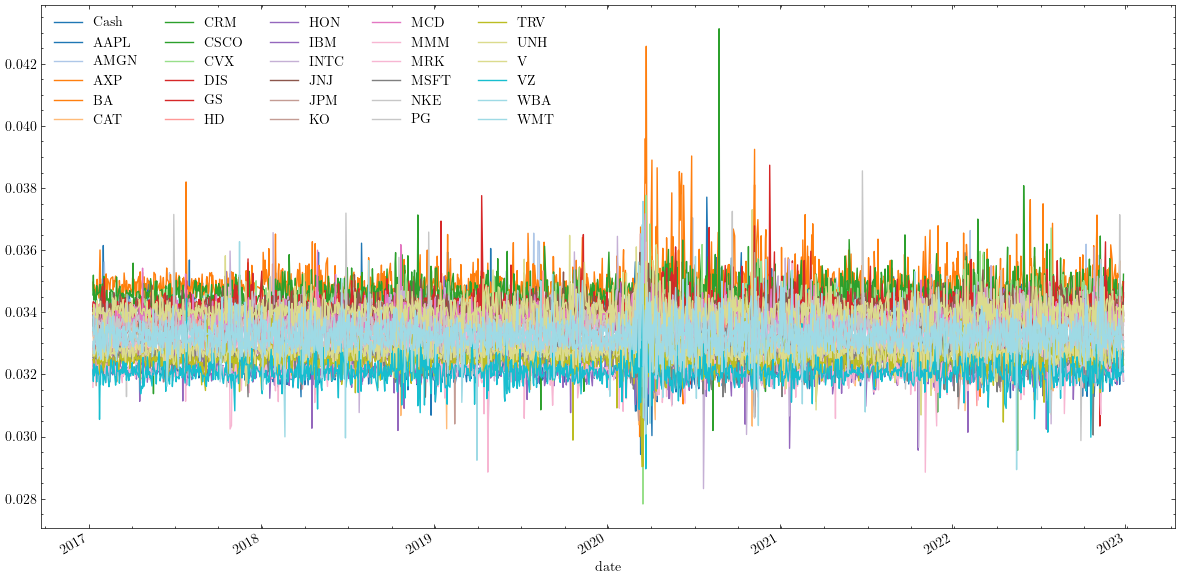

max drowdown: -0.32274258980341164 Sharp ratio: 0.7270892544556627


In [128]:
with plt.style.context('science','ieee'):
    # w.iloc[1:,].plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="summer").legend(ncol=5,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    weights.iloc[1:,].plot(x='date',figsize=(12,6),colormap="tab20")
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()
    print('max drowdown:', qs.stats.max_drawdown(result_sac['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_sac['test'][0].daily_return))


In [142]:
iterations = 120_000
result_ddpg = train_model(train_data,train_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',load=True,tag='dow30')
result_ppo = train_model(train_data,train_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='dow30')
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1000000,load=True,tag='dow30')
result_td3 = train_model(train_data,train_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='dow30')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 16152.1806640625
Final accumulative portfolio value: 2.0190225830078123
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 14687.2021484375
Final accumulative portfolio value: 1.8359002685546875
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 15100.9013671875
Final accumulative portfolio value: 1.8876126708984375
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 15126.587890625
Final accumulative portfolio value: 1.890823486328125
hit end!


In [140]:
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=1000000,load=True,tag='dow30')


{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9068.279296875
Final accumulative portfolio value: 1.133534912109375
hit end!


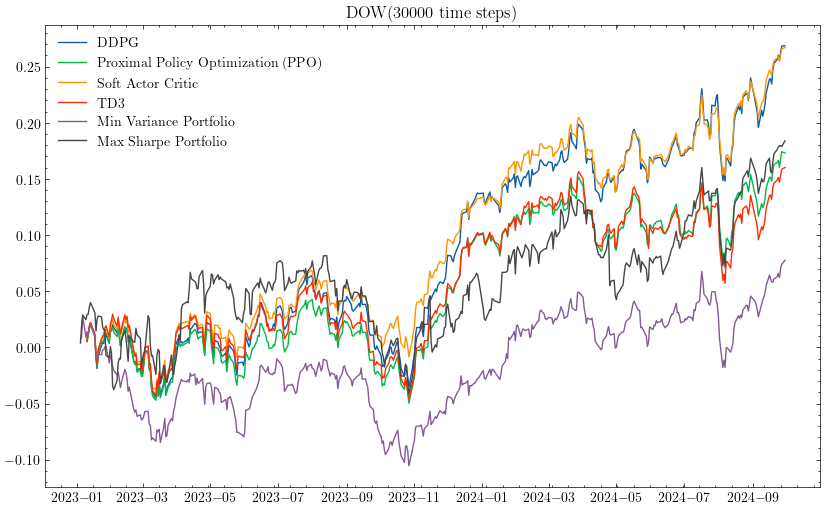

In [134]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

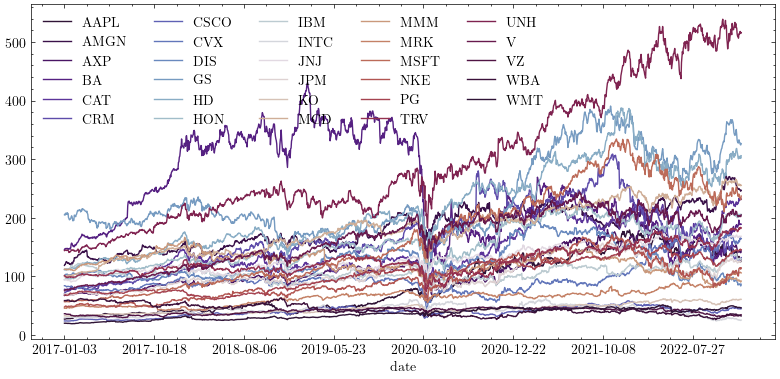

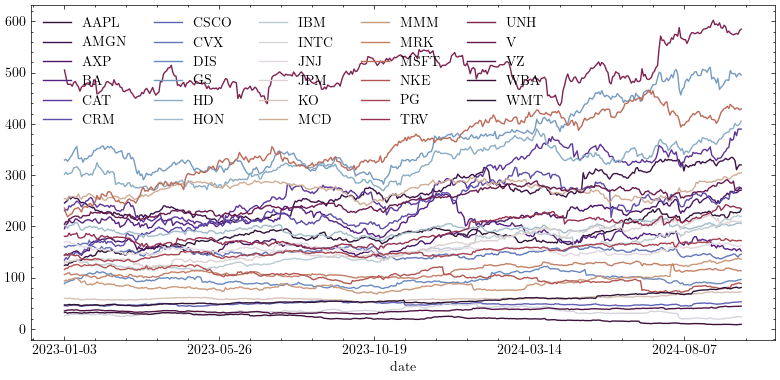

In [9]:
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = train_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    

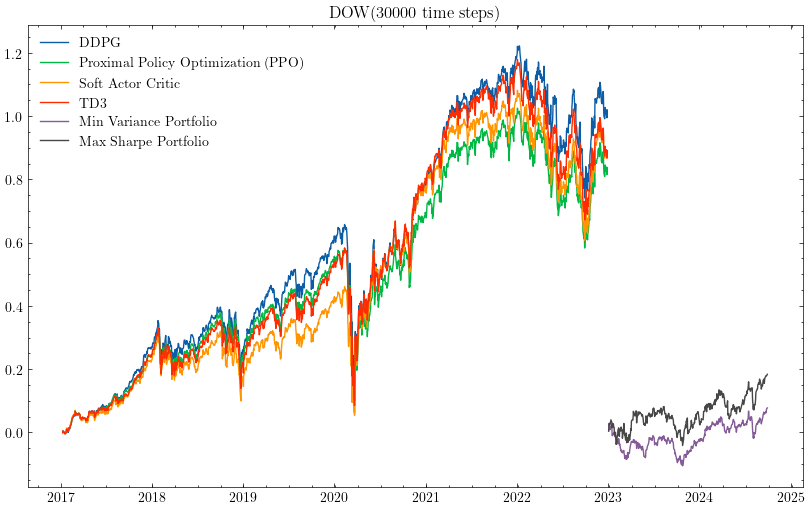

In [ ]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(mvo_result['test'].get('date'),(mvo_result['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(mvo_result_max['test'].get('date'),(mvo_result_max['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [16]:
iterations = 120_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',load=True,tag='dow30_sharpe',use_sharpe=True)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='dow30_sharpe',use_sharpe=True)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,load=True,tag='dow30_sharpe',use_sharpe=True)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='dow30_sharpe',use_sharpe=True)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10291.1943359375
Final accumulative portfolio value: 1.2863992919921876
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9424.6005859375
Final accumulative portfolio value: 1.1780750732421874
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9637.515625
Final accumulative portfolio value: 1.204689453125
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9447.6650390625
Final accumulative portfolio value: 1.1809581298828125
hit end!


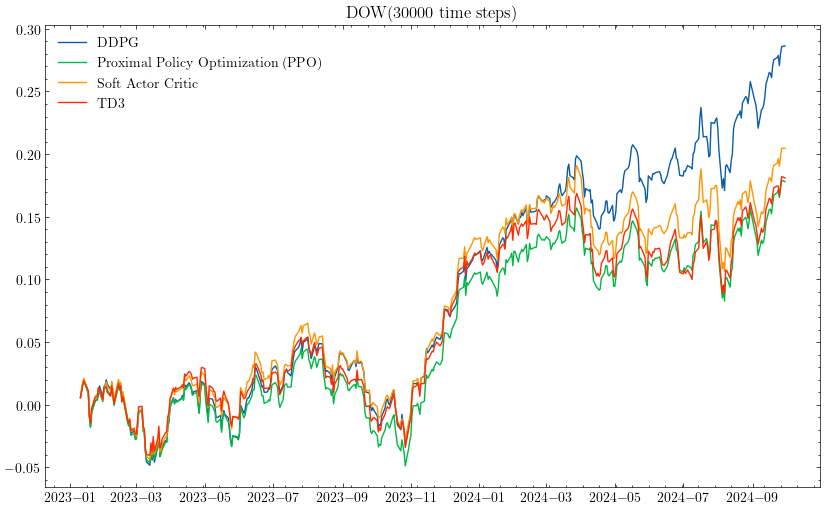

In [17]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.legend()
    plt.title('DOW(30000 time steps)')

In [11]:
# encoding: utf-8
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

dt = df_sp500.query("date> '2005-01-01'")['close']
pct = dt.pct_change().ffill().fillna(0.0)
pct = pct.values

def sharpe(ls):
    return np.mean(ls)/np.std(ls)

freq = 252
ls1 = []
sr0 = sharpe(pct[:freq])
for i in range(500):
    sr = sharpe(pct[:freq+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# ls2 uses cumulated DSR to approximate SR 
ls2 = []
eta = 0.002
# use the first 200 days to set an initial value of SR
sr = sharpe(pct[:freq]) 
print(sr)
for i in range(500):
    A = np.mean(pct[:freq+i])
    B = np.mean(pct[:freq+i]**2)
    delta_A = pct[freq+i+1] - A
    delta_B = pct[freq+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    print(Dt*eta)
    sr += eta * Dt
    ls2.append(Dt*eta)

0.22922770463572564
-0.0005161285309821036
-0.00020637156973838712
6.487055902451664e-05
-0.00020049524177508465
-0.00014711270704077757
-0.0004794518842692132
-0.0006944420291596554
-0.019358018493164403
-0.00037820220439200545
0.0002811699868600998
-0.00048469773108922456
0.0012038274864825246
-0.0004097042637077974
0.00013515966795319917
-0.000312446165623296
-0.00019108469319602226
-0.0003215429874165384
-0.0002161466986848402
0.00026778938181864364
-0.0004309630567890684
0.0001389186828107922
-8.961606584280944e-05
-0.0004256610416367961
0.00040545994951341407
-0.00030284675374853484
-0.0004042594869766843
4.170891099327931e-05
-4.103254426767599e-05
-0.00034390049751309833
-0.00024351162289191865
-0.0001511408459291697
-0.0003952160968980469
-0.00010815349284304511
0.00016661352786297542
-0.00021720630763548892
-0.00023646254162261004
-0.00045608890656645087
0.000605539850966313
-1.3183500029932025e-05
-0.0003633847578975285
-0.00043389283306529515
0.0001705064195268933
-0.000198

In [12]:
iterations = 120_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',tag='dow30_dsr',use_dsr=True)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
result_ppo = train_model(train_data,train_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='dow30')
result_sac = train_model(train_data,train_data,transaction_fee=0.001,model_name='sac',iterations=1000000,load=True,tag='dow30')
result_td3 = train_model(train_data,train_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='dow30')

In [15]:
returns = np.random.normal(loc=0.01, scale=0.02, size=1000)  # Mean 1%, Std Dev 2%


In [45]:
ls2 = []
freq = 252
eta = 0.0001
ls1 = []
sr0 = sharpe(returns[:freq])
for i in range(747):
    sr = sharpe(returns[:freq+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# use the first 200 days to set an initial value of SR
sr = sharpe(returns[:freq]) 
for i in range(747):
    A = np.mean(returns[:freq+i])
    B = np.mean(returns[:freq+i]**2)
    delta_A = returns[freq+i+1] - A
    delta_B = returns[freq+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    sr += eta * Dt
    ls2.append(Dt*eta)

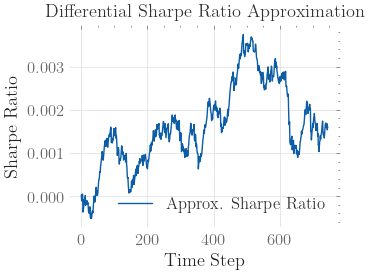

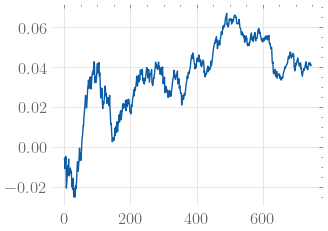

In [46]:

plt.plot(np.array(ls2).cumsum(), label="Approx. Sharpe Ratio")

plt.title("Differential Sharpe Ratio Approximation")
plt.xlabel("Time Step")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.show()
plt.plot(np.array(ls1).cumsum(), label=" Sharpe Ratio")
plt.show()


In [62]:
# encoding: utf-8
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

pct = df_sp500['close'].pct_change().ffill().fillna(0.0)
pct = returns

def sharpe(ls):
    return np.mean(ls)/np.std(ls)

# ls1 contains the true SR values
ls1 = []
feq = 100
sr0 = sharpe(pct[:freq])
for i in range(500):
    sr = sharpe(pct[:freq+i+1])
    ls1.append(sr-sr0)
    sr0 = sr

# ls2 uses cumulated DSR to approximate SR 
ls2 = []
eta = 0.001
# use the first freq days to set an initial value of SR
sr = sharpe(pct[:freq]) 
for i in range(500):
    A = np.mean(pct[:freq+i])
    B = np.mean(pct[:freq+i]**2)
    delta_A = pct[freq+i+1] - A
    delta_B = pct[freq+i+1]**2 - B
    Dt = (B*delta_A - 0.5*A*delta_B) / (B-A**2)**(3/2)
    sr += eta * Dt
    ls2.append(Dt*eta)
print(sr)
print(sr0)


0.5084640695477123
0.537442748271409


# DAX

In [81]:
INDICATORS = [
    "close_5_ema",
    'macd',
    'rsi'
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dax[df_dax["date"] > TRAIN_START_DATE])
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 19, State Space: 96


In [ ]:
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0,rf=0)
min_variance_portfolio = mvo(covs,pct=0,rf=0)

In [88]:
min_variance_portfolio = mvo(covs,pct=0,rf=0)

begin_total_asset:50000
end_total_asset:68170.34600166662
Sharpe:  1.7777986611606376
Test Finished!
episode_return 1.3634069200333325


In [90]:
stock_dimension = len(test_data.tic.unique())

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=50_000,
    comission_fee_pct=0.001,
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [0] + [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Episode:1
Initial portfolio value:50000
Final portfolio value: 64170.66796875
Final accumulative portfolio value: 1.283413359375


In [94]:
environment_train_buy_and_hold._asset_memory["final"]

[50000,
 50343.492,
 50333.918,
 50965.055,
 51447.625,
 51438.324,
 51785.21,
 51779.273,
 51546.22,
 50752.26,
 51126.31,
 51360.246,
 51275.023,
 51198.527,
 51314.355,
 51313.82,
 51748.902,
 51648.15,
 51689.773,
 52505.895,
 52475.375,
 52144.703,
 52145.7,
 52462.64,
 52796.336,
 51916.26,
 52183.47,
 52298.36,
 52529.797,
 52782.78,
 52761.188,
 52787.75,
 52493.34,
 52626.2,
 52463.92,
 51522.055,
 52133.56,
 51993.367,
 51588.57,
 51744.098,
 52581.426,
 52675.918,
 52287.723,
 52696.215,
 52552.51,
 51952.246,
 50562.88,
 51263.473,
 49664.96,
 50192.72,
 49474.32,
 49937.47,
 50983.004,
 51021.566,
 50938.074,
 50029.63,
 50745.824,
 50896.902,
 51437.125,
 52200.863,
 52713.977,
 52722.344,
 52741.305,
 52635.215,
 52963.42,
 53298.625,
 53184.617,
 53345.95,
 53892.44,
 53767.12,
 53985.004,
 54051.195,
 53526.086,
 53923.88,
 53923.75,
 53735.832,
 53601.86,
 53716.934,
 54265.75,
 53543.836,
 53855.453,
 53627.566,
 54665.68,
 54615.434,
 54914.004,
 54902.723,
 54707.1

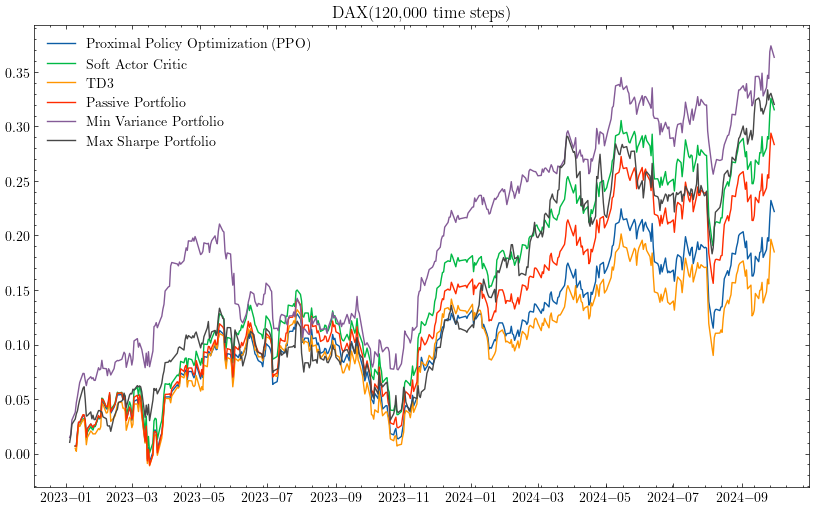

In [96]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod()-1,label = 'Passive Portfolio')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [ ]:
iterations = 120_000
result_ddpg =train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,iterations=iterations,model_name='ddpg',tag='dax_SHARPE')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,model_name='ppo',iterations=iterations,tag='dax_SHARPE')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,model_name='sac',iterations=iterations,tag='dax_SHARPE')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,load=True,use_sharpe=True,model_name='td3',iterations=iterations,tag='dax_SHARPE')

In [97]:
iterations = 120_000
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=True,model_name='ppo',iterations=iterations,tag='dax_SHARPE')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=True,model_name='sac',iterations=iterations,tag='dax_SHARPE')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=True,model_name='td3',iterations=iterations,tag='dax_SHARPE')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model


ValueError: Observation spaces do not match: Box(-inf, inf, (1, 27, 5), float32) != Box(-inf, inf, (1, 19, 5), float32)

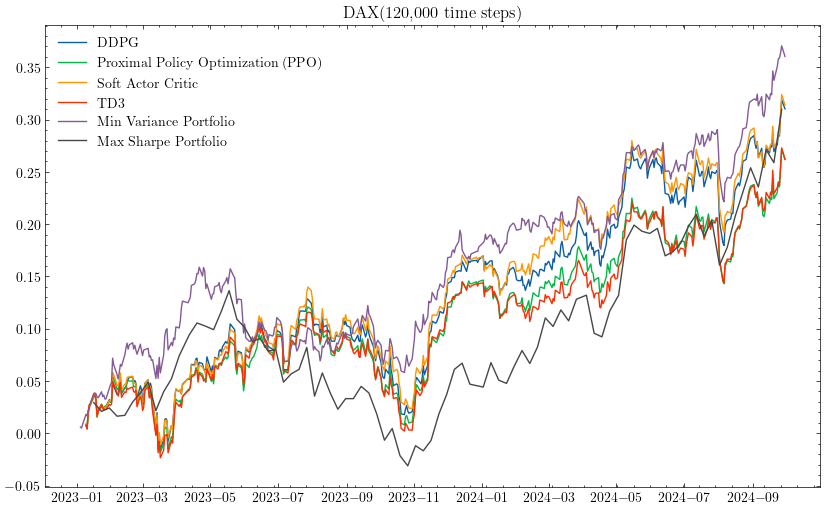

In [16]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

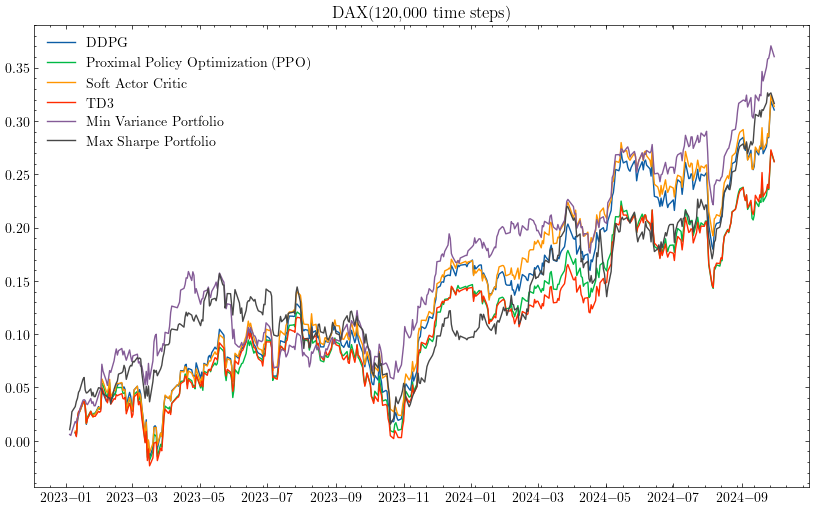

In [18]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

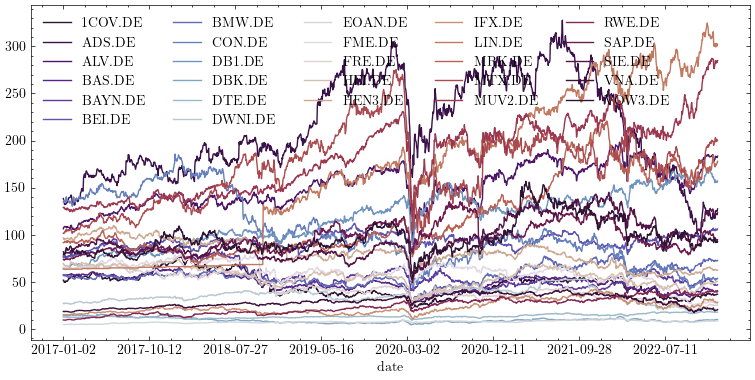

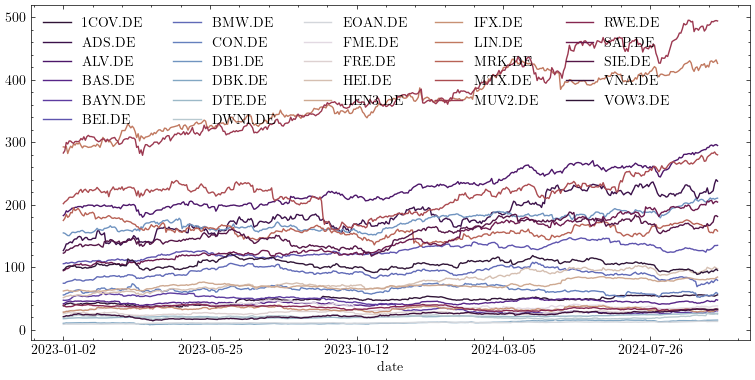

In [21]:
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = train_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(8,4),colormap='twilight_shifted')
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout() 
    

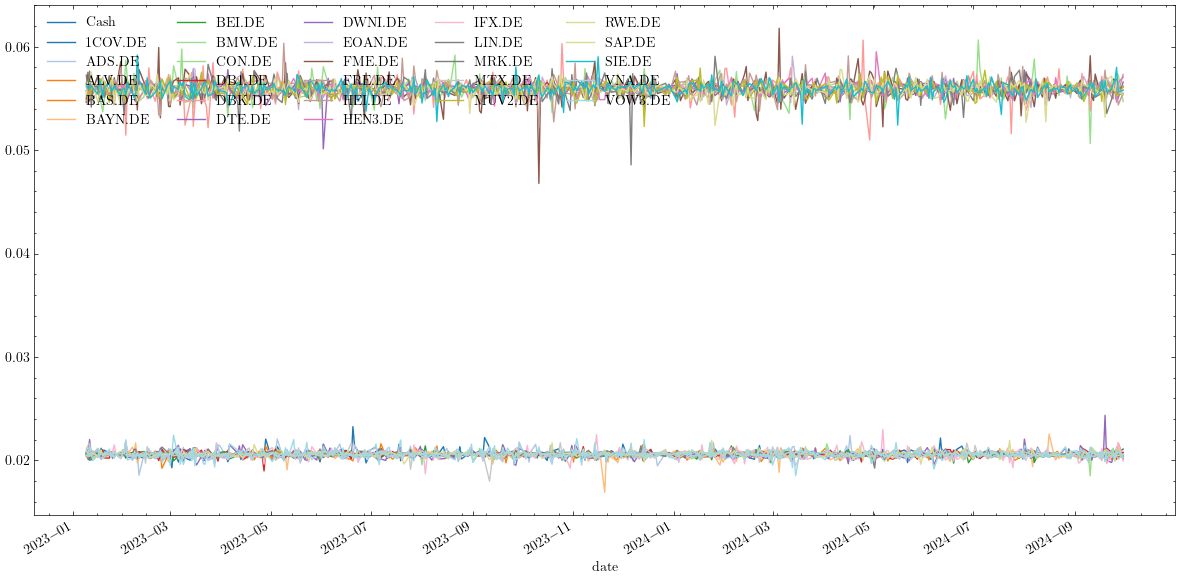

max drowdown: -0.09788244842901161 Sharp ratio: 1.3919193545781623


In [24]:
weights = pd.DataFrame(result_ddpg['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.insert(0,'Cash')
weights.columns = columns
columns.append('date')
weights['date'] = result_ddpg['test'][0].date
# weights["sum"] = weights.drop(columns=["date"]).sum(axis=1)
weights
with plt.style.context('science','ieee'):
    # w.iloc[1:,].plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="summer").legend(ncol=5,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    weights.iloc[1:,].plot(x='date',figsize=(12,6),colormap="tab20")
    plt.legend(ncol=5, bbox_to_anchor=(0, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()
    print('max drowdown:', qs.stats.max_drawdown(result_ddpg['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_ddpg['test'][0].daily_return))


In [25]:
INDICATORS = [
    "close_5_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_sp500)
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 236, State Space: 709


In [42]:
df[df['return']> 0.1]

Unnamed: 0        date        open        high         low  \
165116      2744916  2020-01-07   29.930000   32.580002   29.500000   
760335      2751661  2020-01-29   62.650574   64.793755   62.251846   
296432      2754206  2020-02-06   57.549999   59.799999   56.840000   
340215      2762158  2020-03-04  208.039993  211.940002  205.350006   
445251      2762175  2020-03-04   50.000000   52.830002   49.779999   
...             ...         ...         ...         ...         ...   
1776831     3259750  2024-08-21  167.330002  167.399994  158.970001   
236309      3262086  2024-08-29  102.650002  103.709999   97.650002   
420122      3262127  2024-08-29  104.099998  106.580002  100.739998   
1435477     3265464  2024-09-10  154.229996  160.520004  153.119995   
1330453     3270781  2024-09-26  113.099998  114.800003  107.529999   

              close     volume   tic  day  close_5_ema    return  log_return  
165116    29.530380   37002300   APA    1    25.329622  0.267941    0.237394  
760335    63.187878   44278356    GE    2    58.994863  0.103154    0.098174  
296432    50.501759    6735000   CAH    3    47.042089  0.105922    0.100680  
340215   196.418320    6127800    CI    2   184.761496  0.107212    0.101845  
445251    45.411266    9420400   CPB    2    42.246478  0.101086    0.096297  
...             ...        ...   ...  ...          ...       ...         ...  
1776831  158.106659   25572100   TGT    2   146.236525  0.112003    0.106163  
236309    99.229469   12091200   BBY    3    91.032170  0.141132    0.132021  
420122   105.730003    2658000   COO    3    98.179856  0.118363    0.111866  
1435477  155.540253   37374200  ORCL    1   145.460734  0.114376    0.108294  
1330453  109.756416  107965900    MU    3    98.612386  0.147332    0.137439  

[890 rows x 12 columns]

In [58]:
len(processed_dax.tic.unique())

236

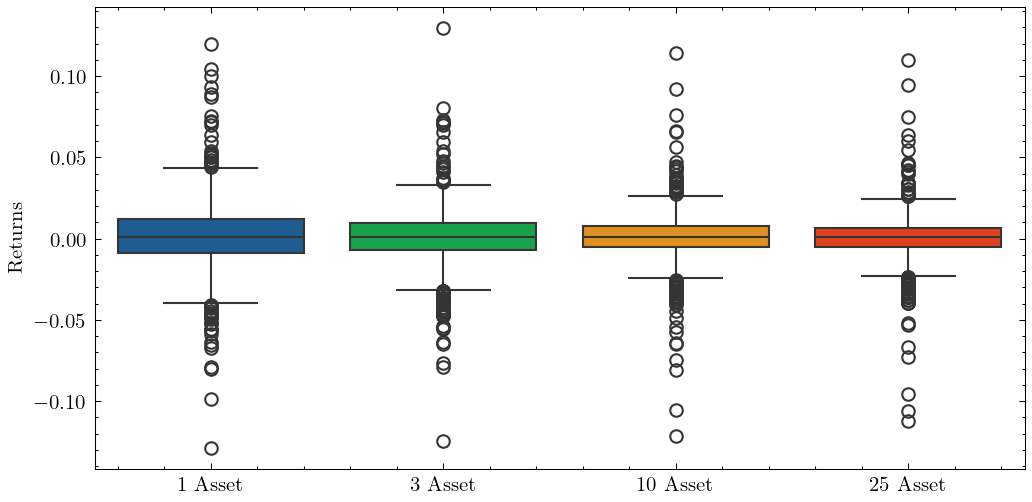

In [80]:
import seaborn as sns
df = processed_dax[processed_dax.date>'2020-01-01'].copy()
pv = df.pivot(index='date',columns='tic',values='return')
%matplotlib inline
with plt.style.context('science','ieee'):
    fig = plt.figure(figsize=(8, 4), dpi=150)
    single_asset = pv['AAPL']
    portfolio_3 = pv.iloc[:, 0:3].mean(axis=1)
    portfolio_10 = pv.iloc[:, 0:10].mean(axis=1)
    portfolio_20 = pv.iloc[:, 0:50].mean(axis=1)

    # Combine the data into a DataFrame for easy plotting
    import pandas as pd
    data = pd.DataFrame({
        "1 Asset": single_asset,
        "3 Asset": portfolio_3,
        "10 Asset": portfolio_10,
        "25 Asset": portfolio_20
    })


    # Create the boxplot
    sns.boxplot(data=data, palette="Set2")

    plt.ylabel("Returns")
    plt.show()


In [91]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=100000,model_name='ddpg',save=True,tag='27dec')
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=100000,save=True,tag='27dec')
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=100000,save=True,tag='27dec')
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=100000,save=True,tag='27dec')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Episode:1
Initial portfolio value:8000
Final portfolio value: 17409.62109375
Final accumulative portfolio value: 2.17620263671875
Episode:2
Initial portfolio value:8000
Final portfolio value: 17012.708984375
Final accumulative portfolio value: 2.126588623046875
Episode:3
Initial portfolio value:8000
Final portfolio value: 16505.921875
Final accumulative portfolio value: 2.063240234375
Episode:4
Initial portfolio value:8000
Final portfolio value: 17113.951171875
Final accumulative portfolio value: 2.139243896484375
Episode:5
Initial portfolio value:8000
Final portfolio value: 17258.734375
Final accumulative portfolio value: 2.157341796875
Episode:6
Initial portfolio value:8000
Final portfolio value: 18081.6171875
Final accumulative portfolio value: 2.2602021484375
Episode:7
Initial portfolio value:8000
Final portfolio value: 18482.54296875
Final accumulative portfolio value: 2.31031787109375
Episode:8
Initial portfolio va

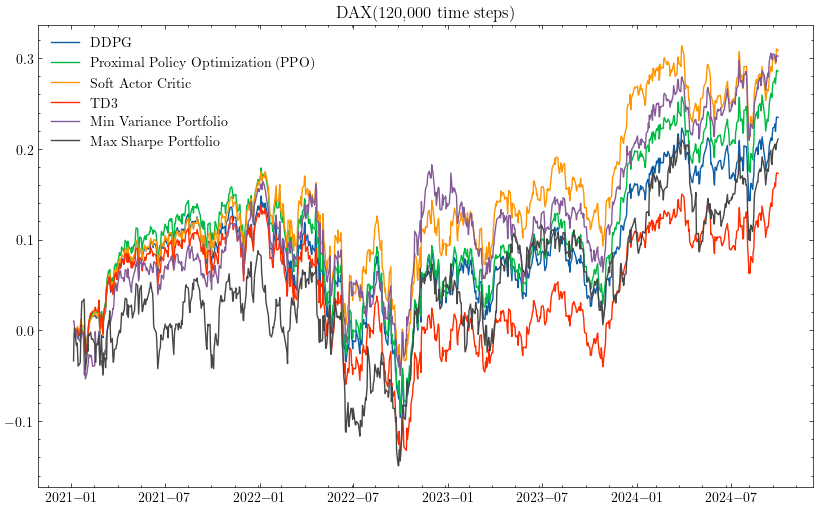

In [93]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [96]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 256,
}

In [97]:
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=500_000,save=True,tag='27dec',args=PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 256}
Episode:1
Initial portfolio value:8000
Final portfolio value: 9098.7236328125
Final accumulative portfolio value: 1.1373404541015626
Episode:2
Initial portfolio value:8000
Final portfolio value: 9481.9052734375
Final accumulative portfolio value: 1.1852381591796874
Episode:3
Initial portfolio value:8000
Final portfolio value: 9004.09375
Final accumulative portfolio value: 1.12551171875
Episode:4
Initial portfolio value:8000
Final portfolio value: 8889.3916015625
Final accumulative portfolio value: 1.1111739501953124
Episode:5
Initial portfolio value:8000
Final portfolio value: 9078.318359375
Final accumulative portfolio value: 1.134789794921875
Episode:6
Initial portfolio value:8000
Final portfolio value: 9180.017578125
Final accumulative portfolio value: 1.147502197265625
Episode:7
Initial portfolio value:8000
Final portfolio value: 8927.8427734375
Final accumulative portfolio value: 1.1159803466796876
Ep

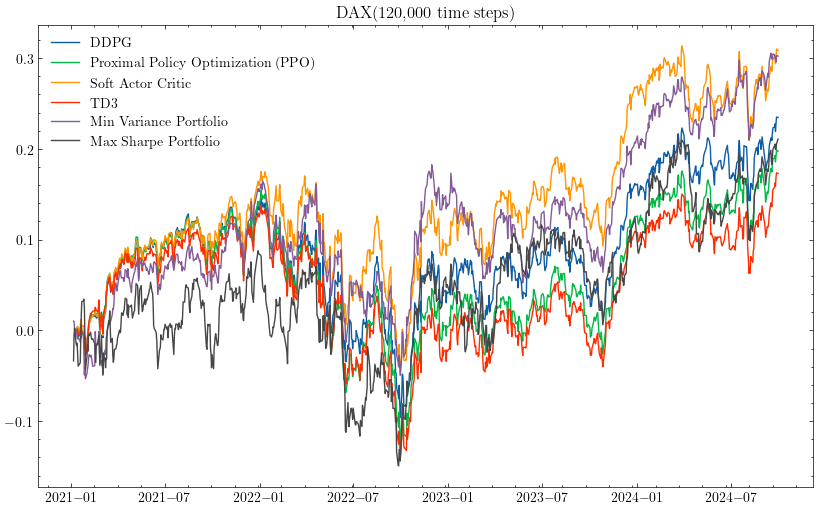

In [98]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [21]:
iterations = 120_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',load=True,tag='29dec',t=1)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=iterations,load=True,tag='29dec',t=1)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=iterations,load=True,tag='29dec',t=1)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=iterations,load=True,tag='29dec',t=1)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10803.5380859375
Final accumulative portfolio value: 1.3504422607421875
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9995.5625
Final accumulative portfolio value: 1.2494453125
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10605.193359375
Final accumulative portfolio value: 1.325649169921875
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9876.150390625
Final accumulative portfolio value: 1.234518798828125
hit end!


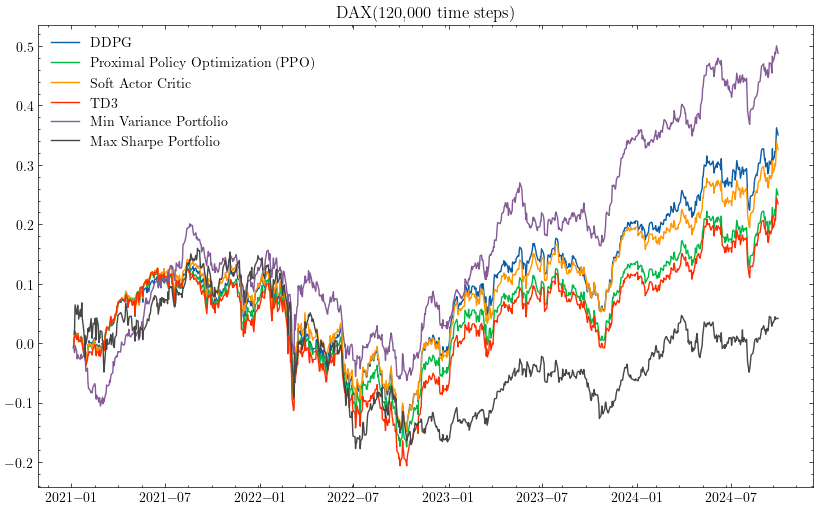

In [22]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [29]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
idx = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['dax']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (994, 8)


In [45]:
index_data = idx.copy()
index_data['return'] = idx['close'].pct_change()
index_data['date'] = pd.to_datetime(index_data['date'], format='%d%b%Y:%H:%M:%S.%f')

ValueError: time data "2021-01-04" doesn't match format "%d%b%Y:%H:%M:%S.%f", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [44]:
index_data.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
tic        object
day         int32
return    float64
dtype: object

In [19]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=100000,model_name='ddpg',load=True,tag='29dec_t3',t=3)
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,model_name='ppo',iterations=100000,load=True,tag='29dec_t3',t=3)
result_sac = train_model(train_data,test_data,transaction_fee=0.001,model_name='sac',iterations=100000,load=True,tag='29dec_t3',t=3)
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,model_name='td3',iterations=100000,load=True,tag='29dec_t3',t=3)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9927.658203125
Final accumulative portfolio value: 1.240957275390625
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 9972.640625
Final accumulative portfolio value: 1.246580078125
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10896.1220703125
Final accumulative portfolio value: 1.3620152587890626
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:8000
Final portfolio value: 10760.248046875
Final accumulative portfolio value: 1.345031005859375
hit end!


In [69]:
TEST_STARTD_DATE = '2023-01-01'
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)

In [60]:
z = covs[covs.time> TEST_STARTD_DATE]

In [77]:
min_variance_portfolio = mvo(z,pct=0,rf=0)

begin_total_asset:50000
end_total_asset:71657.21816787958
Sharpe:  2.1102407136517933
Test Finished!
episode_return 1.4331443633575915


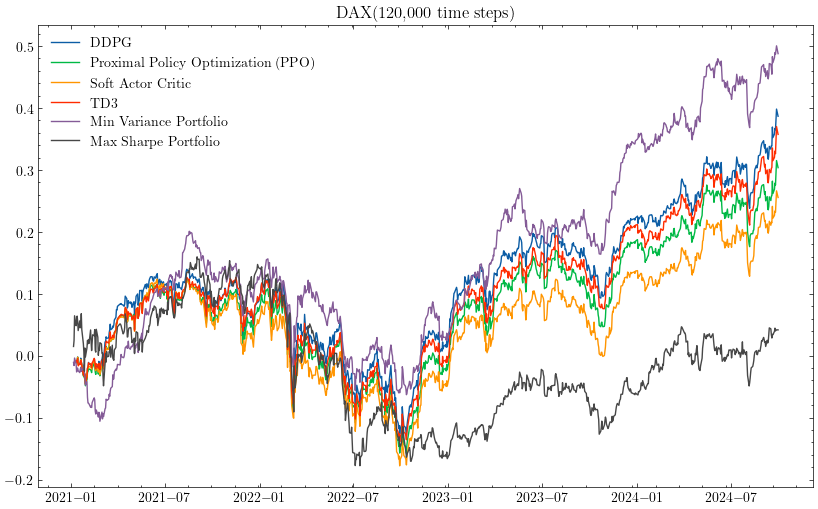

In [55]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')    
    plt.legend()
    plt.title('DAX(120,000 time steps)')

In [51]:
train_data[train_data.tic == "ADS.DE"].head(80)

Unnamed: 0        date       open       high        low      close  \
0        70960  2010-01-04  37.959999  38.525002  37.685001  31.563414   
1        70985  2010-01-05  39.000000  40.049999  38.820000  32.559383   
2        71010  2010-01-06  39.799999  40.064999  39.095001  32.297070   
3        71035  2010-01-07  39.365002  40.000000  39.115002  32.579872   
4        71060  2010-01-08  39.724998  39.994999  39.250000  32.461010   
..         ...         ...        ...        ...        ...        ...   
75       72835  2010-04-21  41.935001  42.799999  41.669998  34.870998   
76       72860  2010-04-22  42.665001  43.169998  41.799999  35.096416   
77       72885  2010-04-23  44.250000  44.910000  43.660000  36.473553   
78       72910  2010-04-26  44.775002  45.049999  44.500000  36.768654   
79       72935  2010-04-27  44.775002  45.154999  43.875000  36.035004   

     volume     tic  day  close_5_ema      macd         rsi    return  \
0    953276  ADS.DE    0    31.563414  0.000000  100.000000  0.031555   
1   2463075  ADS.DE    1    32.160995  0.022345  100.000000  0.031555   
2   1099488  ADS.DE    2    32.225452  0.020338   77.903769 -0.008056   
3   1085415  ADS.DE    3    32.372672  0.029137   82.415102  0.008756   
4    719621  ADS.DE    4    32.406584  0.028575   75.443194 -0.003648   
..      ...     ...  ...          ...       ...         ...       ...   
75  2137456  ADS.DE    2    34.330929  0.802772   71.921921  0.012857   
76  2918570  ADS.DE    3    34.586091  0.841808   73.332209  0.006464   
77  3365049  ADS.DE    4    35.215245  0.972400   79.955895  0.039239   
78  1120438  ADS.DE    0    35.733048  1.087117   81.042502  0.008091   
79  1216210  ADS.DE    1    35.833700  1.106191   70.770795 -0.019953   

    log_return  
0     0.031067  
1     0.031067  
2    -0.008089  
3     0.008718  
4    -0.003655  
..         ...  
75    0.012775  
76    0.006444  
77    0.038488  
78    0.008058  
79   -0.020155  

[80 rows x 14 columns]

In [65]:
iterations = 200_000
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,load=True,iterations=iterations,model_name='ddpg',tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])
result_ppo = train_model(train_data,test_data,transaction_fee=0.001,load=True,model_name='ppo',iterations=iterations,tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])
result_sac = train_model(train_data,test_data,transaction_fee=0.001,load=True,model_name='sac',iterations=iterations,tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])
result_td3 = train_model(train_data,test_data,transaction_fee=0.001,load=True,model_name='td3',iterations=iterations,tag='29dec_indicators',t=5,features=['close','log_return','rsi','macd'])

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 69334.2734375
Final accumulative portfolio value: 1.38668546875
hit end!
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 65182.9609375
Final accumulative portfolio value: 1.30365921875
hit end!
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 62774.58203125
Final accumulative portfolio value: 1.255491640625
hit end!
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
loading model
Episode:1
Initial portfolio value:50000
Final portfolio value: 67867.6171875
Final accumulative portfolio value: 1.35735234375
hit end!


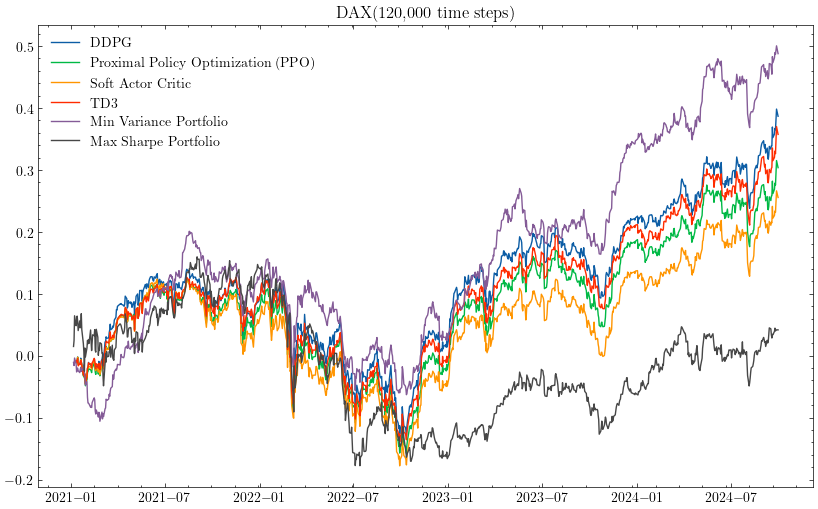

In [54]:
import quantstats as qs
%matplotlib inline
with plt.style.context('science','ieee'):
    plt.figure(figsize=(10, 6))
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0].account.pct_change()+ 1).cumprod()-1,label='DDPG')
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0].account.pct_change()+ 1).cumprod()-1,label='Proximal Policy Optimization (PPO)')
    plt.plot(result_sac['test'][0].get('date'),(result_sac['test'][0].account.pct_change()+ 1).cumprod()-1,label='Soft Actor Critic')
    plt.plot(result_td3['test'][0].get('date'),(result_td3['test'][0].account.pct_change()+ 1).cumprod()-1,label='TD3')
    plt.plot(min_variance_portfolio['test'].get('date'),(min_variance_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Min Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].get('date'),(max_sharpe_portfolio['test'].account.pct_change()+ 1).cumprod()-1,label='Max Sharpe Portfolio')    
    plt.legend()
    plt.title('DAX(120,000 time steps)')